## Projeto Recomendação de Filmes

#### O que faremos?

Criaremos algoritimos de recomendadores de filmes para alguns cenários:
- Com base nos filmes mais populares (para usuários novos na plataforma)
- Com base em histórico de consumo do usuário
- Com base em escolhas da rede de contatos do usuário.


#### De onde consumiremos?

Neste projeto, consumiremos bases de filmes disponibilizada pelo GroupLens, que é um grupo de pesquisa da universidade de Minnesota que possui publicações em diversas áreas de estudo.
fontes:
- https://grouplens.org/
- https://movielens.org/

#### Como dividiremos o projeto?

Dividiremos o projeto da seguinte forma:
- Import das ferramentas que utilizaremos
- Ingestão dos dados
- Tratamento dos dados
    - Verificação de Nnlos
    - Verificação de valores duplicados
    - Merge das tabelas
    - Remoção de outliers
- Identificação de variáveis categóricas e modelagem do DataFrame
- Clusterização utilizando o KMeans
- Desenvolvimento do modelo


---------------------------------------------------------------------

###### Import das ferramentas

In [401]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
os.chdir("C:\\Users\\fcanuto\Desktop\\estudos\\ml-latest-small")

np.random.seed(44)

###### Ingerindo as bases

In [277]:
filmes = pd.read_csv("movies.csv")
notas = pd.read_csv("ratings.csv")

###### Verificando a estrutura das bases

In [278]:
filmes.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [279]:
notas.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


###### Verificando valores nulos

In [280]:
filmes.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [281]:
notas.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

###### Verificando e Removendo filmes duplicados

In [282]:
filmes.title.value_counts()

Eros (2004)                               2
Saturn 3 (1980)                           2
Emma (1996)                               2
Confessions of a Dangerous Mind (2002)    2
War of the Worlds (2005)                  2
                                         ..
Bikini Beach (1964)                       1
Where the Wild Things Are (2009)          1
Merchant of Venice, The (2004)            1
Invincible Iron Man, The (2007)           1
Casino Royale (1967)                      1
Name: title, Length: 9737, dtype: int64

In [283]:
filmes_duplicados = filmes[filmes.duplicated(subset="title")]["movieId"].tolist()
filmes = filmes.query(f'movieId not in {filmes_duplicados}')

In [284]:
filmes.title.value_counts()

Halloweentown (1998)                     1
Cat on a Hot Tin Roof (1958)             1
Dawn of the Planet of the Apes (2014)    1
Dave (1993)                              1
Anvil! The Story of Anvil (2008)         1
                                        ..
Bikini Beach (1964)                      1
Where the Wild Things Are (2009)         1
Merchant of Venice, The (2004)           1
Invincible Iron Man, The (2007)          1
Casino Royale (1967)                     1
Name: title, Length: 9737, dtype: int64

In [257]:
notas_duplicadas = notas[notas.duplicated(subset="movieId")]['movieId'].tolist()
notas = notas.query(f'movieId not in {notas_duplicadas}')

In [285]:
notas

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [286]:
notas.movieId.value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
5986        1
100304      1
34800       1
83976       1
8196        1
Name: movieId, Length: 9724, dtype: int64

###### Merge das tabelas

In [287]:
notas

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [288]:
filmes_notas = notas.merge(filmes, on='movieId')

In [289]:
filmes_notas.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


Verificando os filmes com maiores avaliações

In [290]:
filmes_notas.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Name: rating, dtype: float64

Verificando quantos votos tiveram

In [291]:
filmes_notas[filmes_notas.title == 'Karlson Returns (1970)']

,userId,movieId,rating,timestamp,title,genres
88669,105,172585,5.0,1526207575,Karlson Returns (1970),Adventure|Animation|Children


In [292]:
media = notas.groupby('movieId')['rating'].mean()
media['movieId'] = notas['movieId']

In [293]:
filmes = filmes.merge(media, on='movieId')

In [294]:
filmes.columns = ['movieId', 'title', 'genres', 'average_rating']

In [295]:
filmes.head()

,movieId,title,genres,average_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.43182
2,3,Grumpier Old Men (1995),Comedy|Romance,3.25962
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.35714
4,5,Father of the Bride Part II (1995),Comedy,3.07143


In [296]:
filmes_notas.groupby('title').size().describe()

count    9719.000000
mean       10.374524
std        22.405799
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
dtype: float64

##### Utilizamos filmes_notas para calculo da quantidade das notas

In [297]:
qtde_notas = notas.groupby('movieId').size()
qtde_notas.columns = ['movieId','qtde_notas']
qtde_notas = pd.DataFrame(qtde_notas)
qtde_notas.columns = ['qtde_notas']

In [298]:
notas[notas['movieId'] == 49]

,userId,movieId,rating,timestamp
29386,202,49,3.0,974925453


In [299]:
qtde_teste = filmes_notas.groupby('movieId').size()
qtde_teste.head()

movieId
1    215
2    110
3     52
4      7
5     49
dtype: int64

In [300]:
filmes.columns

Index(['movieId', 'title', 'genres', 'average_rating'], dtype='object')

In [330]:
notas = notas.merge(qtde_notas, how='left', on='movieId')

In [301]:
filmes = filmes.merge(qtde_notas, how='left', on='movieId')

In [331]:
notas

,userId,movieId,rating,timestamp,qtde_notas
0,1,1,4.0,964982703,215
1,1,3,4.0,964981247,52
2,1,6,4.0,964982224,102
3,1,47,5.0,964983815,203
4,1,50,5.0,964982931,204
...,...,...,...,...,...
100831,610,166534,4.0,1493848402,6
100832,610,168248,5.0,1493850091,7
100833,610,168250,5.0,1494273047,15
100834,610,168252,5.0,1493846352,25


In [302]:
filmes

,movieId,title,genres,average_rating,qtde_notas
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.43182,110
2,3,Grumpier Old Men (1995),Comedy|Romance,3.25962,52
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.35714,7
4,5,Father of the Bride Part II (1995),Comedy,3.07143,49
...,...,...,...,...,...
9714,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,4,1
9715,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,3.5,1
9716,193585,Flint (2017),Drama,3.5,1
9717,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,3.5,1


#### Top 5 Filmes mais avaliados

In [303]:
filmes.sort_values(by='qtde_notas', ascending=False).head(5)

,movieId,title,genres,average_rating,qtde_notas
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.16413,329
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.42902,317
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.19707,307
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.16129,279
1938,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.19245,278


## Clusterizando

In [163]:
#filmes = pd.read_csv("movies.csv")
#notas = pd.read_csv("ratings.csv")

In [164]:
# filmes_duplicados = filmes[filmes.duplicated(subset="title")]["movieId"].tolist()
# filmes = filmes.query(f'movieId not in {filmes_duplicados}')

In [165]:
# filmes = notas.merge(filmes, on='movieId')

In [304]:
filmes['genres'].str.split('|')

0       [Adventure, Animation, Children, Comedy, Fantasy]
1                          [Adventure, Children, Fantasy]
2                                       [Comedy, Romance]
3                                [Comedy, Drama, Romance]
4                                                [Comedy]
                              ...                        
9714                 [Action, Animation, Comedy, Fantasy]
9715                         [Animation, Comedy, Fantasy]
9716                                              [Drama]
9717                                  [Action, Animation]
9718                                             [Comedy]
Name: genres, Length: 9719, dtype: object

##### Dando um 'Split' nos generos (dados categóricos) dos filmes e inputando nas colunas

In [305]:
generos = filmes.genres.str.get_dummies('|')

In [306]:
generos['movieId'] = filmes.movieId

In [307]:
filmes = filmes.merge(generos, on='movieId')

In [376]:
filmes

,movieId,title,genres,average_rating,qtde_notas,(no genres listed),Action,Adventure,Animation,Children,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,group
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,4
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.43182,110,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,4
2,3,Grumpier Old Men (1995),Comedy|Romance,3.25962,52,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,7
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.35714,7,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
4,5,Father of the Bride Part II (1995),Comedy,3.07143,49,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9714,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,4,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,9
9715,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,3.5,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4
9716,193585,Flint (2017),Drama,3.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
9717,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,3.5,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,6


##### Analise das colunas

In [377]:
filmes.columns

Index(['movieId', 'title', 'genres', 'average_rating', 'qtde_notas',
       '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western', 'group'],
      dtype='object')

##### Seleção das features para utilização no modelo

In [388]:
features_selecionadas = filmes.columns.difference(['movieId', 'title', 'genres', 'average_rating', 'qtde_notas',
       '(no genres listed)','group'])

In [389]:
X = filmes[features_selecionadas]

##### Verificação de quantos clusters utilizaremos analizando as inércias

In [390]:
inertias = {}
for k in range(1, 40, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
    inertias[k] = kmeans.inertia_

In [391]:
inertias

{1: 16898.58853791542,
 11: 7952.884396509388,
 21: 5943.9843823699475,
 31: 4942.390004960495}

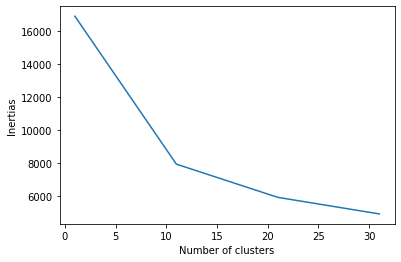

In [392]:
plt.figure()
plt.plot(list(inertias.keys()), list(inertias.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertias")
plt.show()

#### Com base na análise das inércias, utilizaremos 12 clusters para o KMeans

In [393]:
kmeans = KMeans(n_clusters=12)

##### Efetuar o predict com o KMeans

In [394]:
groups = kmeans.fit_predict(X)
filmes["group"] = group

In [395]:
group

array([4, 4, 7, ..., 5, 6, 8])

##### Incluir a coluna group no dataframe

In [396]:
filmes["group"] = group

In [397]:
filmes.head(3)

,movieId,title,genres,average_rating,qtde_notas,(no genres listed),Action,Adventure,Animation,Children,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,group
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,4
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.43182,110,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,4
2,3,Grumpier Old Men (1995),Comedy|Romance,3.25962,52,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,7


In [398]:
filmes.group.values[0]

4

In [502]:
# features_selecionadas = filmes.columns.difference(['movieId', 'title', 'genres', 'average_rating', 'qtde_notas', '(no genres listed)'])
# X = filmes[features_selecionadas]
# groups = kmeans.fit_predict(X)
# filmes["group"] = group

def get_recomendations(movie_title, df=filmes, number_of_films=10):
    # procura pelo nome
    try:
        filme = df[df.title == movie_title]
    except:
        print('Filme não encontrado')
    
        
   # Cálculo do grupo do filme e dos filmes deste grupo
    grupo_do_filme = filme.group.values[0]
    filmes_do_grupo = df[df.group == grupo_do_filme]
    
    # Calculo das distancias para cada filme do grupo e inclusão na coluna 'distance'
    distancias = euclidean_distances(filmes_do_grupo[features_selecionadas], filme[features_selecionadas])
    filmes_do_grupo['distance'] = distancias
    
    
    #retorna os 10 mais proximos dentro do grupo
    print(f"Recomendação para quem assistiu e gostou de '{movie_title}'\n")
    return filmes_do_grupo[filmes_do_grupo.title != movie_title].sort_values('distance').title[:number_of_films]

    

In [501]:
get_recomendations('Batman Returns (1992)')

Recomendação para quem assistiu e gostou de 'Batman Returns (1992)'



C:\Users\fcanuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3279    Way of the Dragon, The (a.k.a. Return of the D...
9257                                Precious Cargo (2016)
6860                                    RocknRolla (2008)
9170                                   Close Range (2015)
4806                                        Torque (2004)
477                              Striking Distance (1993)
8151            Captain America II: Death Too Soon (1979)
4945                              Enter the Dragon (1973)
4571                                         Cobra (1986)
4953                                     Dobermann (1997)
Name: title, dtype: object

##### Agora iremos indicar os filmes com base nas avaliações do usuário

In [451]:
filmes2 = filmes.merge(notas, on='movieId')
filmes2

,movieId,title,genres,average_rating,qtde_notas_x,(no genres listed),Action,Adventure,Animation,Children,...,Romance,Sci-Fi,Thriller,War,Western,group,userId,rating,timestamp,qtde_notas_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,0,0,1,1,1,...,0,0,0,0,0,4,1,4.0,964982703,215
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,0,0,1,1,1,...,0,0,0,0,0,4,5,4.0,847434962,215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,0,0,1,1,1,...,0,0,0,0,0,4,7,4.5,1106635946,215
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,0,0,1,1,1,...,0,0,0,0,0,4,15,2.5,1510577970,215
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215,0,0,1,1,1,...,0,0,0,0,0,4,17,4.5,1305696483,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100825,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,4,1,0,1,0,1,0,...,0,0,0,0,0,9,184,4.0,1537109082,1
100826,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,3.5,1,0,0,0,1,0,...,0,0,0,0,0,4,184,3.5,1537109545,1
100827,193585,Flint (2017),Drama,3.5,1,0,0,0,0,0,...,0,0,0,0,0,5,184,3.5,1537109805,1
100828,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,3.5,1,0,1,0,1,0,...,0,0,0,0,0,6,184,3.5,1537110021,1


In [503]:
def get_recomendations_to(userId):
    
    # Pegar os 10 filmes mais bem avaliados pelo usuário
    filmes_do_usuario = filmes2[filmes2.userId == userId].sort_values('rating', ascending=False)[:10]
    
    # Ordenar pelos 3 mais populares dos 10 selecionados
    mais_populares = filmes_do_usuario.sort_values('qtde_notas_x', ascending=False)[:3]
    #return mais_populares
    
    
    
    for filme in mais_populares.title:
        print(get_recomendations(str(filme), number_of_films=3))
        print()
        
    # recomendar com base nos 3 ordenados
    #for filme in mais_populares.title:
    #    get_recomendations(filme, number_of_films=10)
    #    print()

In [506]:
get_recomendations_to(5)

Recomendação para quem assistiu e gostou de 'Pulp Fiction (1994)'

2451    Man Bites Dog (C'est arrivé près de chez vous)...
520                                          Fargo (1996)
791                                        Freeway (1996)
Name: title, dtype: object

Recomendação para quem assistiu e gostou de 'Schindler's List (1993)'

5840    Special Day, A (Giornata particolare, Una) (1977)
4699                             Midnight Clear, A (1992)
882                                 Paths of Glory (1957)
Name: title, dtype: object

Recomendação para quem assistiu e gostou de 'Dances with Wolves (1990)'

2606                                     True Grit (1969)
5041                         Ride the High Country (1962)
3342    Return to Snowy River (a.k.a. The Man From Sno...
Name: title, dtype: object



C:\Users\fcanuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\fcanuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\fcanuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i